# INDENG 242 Final Project

## Logistic Regression

The purpose of this document is to apply the model of logistic regression to a previously organized and cleaned dataset. We use logistic regression to predict the winning percentage of the blue side (Team1) against the red side (Team2). For the selection of variables, we use VIF to remove variables that have larger values or that we consider more unimportant. Also, we can use k-fold validation to find suitable models.

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from scipy.stats import sem

In [2]:
Team1vsTeam2 = pd.read_excel(r'Team1vsTeam2_2019-2023.xlsx') # The dataset that contain all the match statistics from 2019 to 2023

Team1vsTeam2 = Team1vsTeam2.drop(['index'], axis=1) # Remove the column that contains the team name
Team1vsTeam2

,WR,KD,CKPM,GPR,GSPD,EGR,MLR,FB,FT,F3T,HLD,FD,DRG,ELD,BN,LNE,JNG,WPM,CWPM,IsWin
0,0.119447,0.13,-0.02,0.37,0.014,1.1,10.9,-0.01,0.05,0.03,0.02,0.05,0.03,0.25,0.11,-0.003,-0.004,0.23,0.03,1
1,0.196685,0.35,-0.18,0.33,0.045,4.0,15.2,0.00,-0.07,-0.03,0.12,0.10,0.06,0.00,0.10,-0.001,0.027,0.26,-0.05,1
2,0.030134,0.25,-0.23,0.27,0.025,7.0,-4.0,0.15,0.12,0.06,-0.05,-0.05,0.00,-0.40,0.01,0.002,0.019,-0.02,-0.17,1
3,-0.236601,-0.55,-0.05,-1.07,-0.089,-9.7,-16.2,0.01,-0.07,-0.19,-0.03,0.05,-0.04,0.64,-0.08,-0.012,-0.058,-0.22,-0.17,0
4,0.099203,0.01,0.35,0.27,0.030,-0.4,10.4,-0.10,0.08,0.03,0.10,-0.02,-0.03,0.56,0.06,0.001,0.017,-0.25,-0.57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,-0.109790,-0.30,-0.20,-0.47,-0.027,-5.8,-5.7,-0.12,-0.09,-0.04,-0.05,-0.11,-0.07,-0.09,-0.08,0.000,-0.024,0.26,0.12,1
364,-0.070833,-0.09,-0.02,-0.10,0.019,-7.0,-0.1,-0.15,-0.03,-0.12,0.04,-0.11,-0.02,-0.44,0.01,0.001,0.019,0.56,0.30,0
365,0.103757,-0.03,0.38,0.17,0.022,1.5,9.5,-0.23,0.04,-0.04,-0.10,-0.11,-0.05,0.03,0.10,0.016,0.039,-0.54,-0.28,1
366,0.177327,0.30,0.12,0.60,0.019,8.0,11.2,0.03,-0.01,0.04,-0.10,0.16,0.07,0.51,0.09,-0.001,0.000,0.06,-0.10,1


In [3]:
# Split to train and test set
Team1vsTeam2_train, Team1vsTeam2_test = train_test_split(Team1vsTeam2, test_size=0.2, random_state=88)

Team1vsTeam2_train.shape, Team1vsTeam2_test.shape

((294, 20), (74, 20))

#### Baseline Model
Calculate the Winning rate of blue side(Team1) without any prediction with variables. And we want to create models that performs better than the baseline model.

In [4]:
default_false = np.sum(Team1vsTeam2_train['IsWin'] == 0)  # not Win 
default_true = np.sum(Team1vsTeam2_train['IsWin'] == 1)   # Win

ACC = default_true/(default_false + default_true)

print(pd.Series({'0': default_false, '1': default_true}), 'Accuracy:', ACC)

0    142
1    152
dtype: int64 Accuracy: 0.5170068027210885


A baseline model can be a so-called "dummy" model, where the classifier predicts every new observation as the majority class. In our case, for a datapoint with any given features, the baseline model will always predict that blue side(Team1) will win.

#### Apply the Baseline Model on testing

In [5]:
default_false_test = np.sum(Team1vsTeam2_test['IsWin'] == 0)
default_true_test = np.sum(Team1vsTeam2_test['IsWin'] == 1)
ACC_test = default_true_test/(default_false_test + default_true_test)

ACC_test

0.527027027027027

#### Model Fitting (Logistic Regression)

In [6]:
logreg = smf.logit(formula = 'IsWin ~ WR + KD + CKPM + GPR + GSPD + EGR + MLR + FB + FT + F3T + HLD + FD + DRG + ELD + BN + LNE + JNG + WPM + CWPM',
                   data = Team1vsTeam2_train).fit()

print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.593924
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  IsWin   No. Observations:                  294
Model:                          Logit   Df Residuals:                      274
Method:                           MLE   Df Model:                           19
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.1424
Time:                        00:08:14   Log-Likelihood:                -174.61
converged:                       True   LL-Null:                       -203.62
Covariance Type:            nonrobust   LLR p-value:                 7.973e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0932      0.131      0.712      0.476      -0.163       0.350
WR            14.2685      5.

In [7]:
y_test = Team1vsTeam2_test['IsWin']

y_prob = logreg.predict(Team1vsTeam2_test)
y_pred = pd.Series([1 if x > 0.5 else 0 for x in y_prob], index=y_prob.index)

# y_pred is the vector of probabilities as given by your model on the test set. 
# Values between 0 and 1.

# Remember, P(Yi = 1) = 1/(1 + e^(-(b0 + b1*x1 + b2*x2 +...)) )
y_pred

12     1
212    0
252    0
46     0
138    0
      ..
22     1
251    0
338    0
305    1
319    1
Length: 74, dtype: int64

#### Model Evaluation

In [8]:
cm = confusion_matrix(y_test, y_pred)

# Accuracy
Acc_logit = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())  # T/total = (TP+TN)/total
TPR_logit = (cm.ravel()[3])/(cm.ravel()[2] + cm.ravel()[3])  # TP/TP + FN
FPR_logit = (cm.ravel()[1])/(cm.ravel()[0] + cm.ravel()[1])  # FP/TN + FP
print('The test Accuracy:', Acc_logit, 'TPR: ', TPR_logit, 'FPR: ', FPR_logit)

The test Accuracy: 0.6216216216216216 TPR:  0.7435897435897436 FPR:  0.5142857142857142


---
#### Variable Selection
VIF

In [9]:
# calculate Variance Inflation Factor for each explanatory variable
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

cols = ['WR', 'KD', 'CKPM', 'GPR', 'GSPD', 'EGR', 'MLR', 'FB', 'FT', 'F3T', 'HLD', 'FD', 'DRG', 'ELD', 'BN', 'LNE', 'JNG', 'WPM', 'CWPM']
VIF(Team1vsTeam2_train, cols)

WR      24.001994
KD      11.567447
CKPM     3.699425
GPR     18.184409
GSPD    16.390459
EGR     17.694750
MLR      7.161146
FB       2.080932
FT       3.103699
F3T      4.825298
HLD      2.562047
FD       3.719194
DRG      6.570563
ELD      1.938764
BN       4.873084
LNE      2.047635
JNG      4.423578
WPM      3.737871
CWPM     3.974254
dtype: float64

In [10]:
# remove WR(Win Rate) because of its high VIF
# GPR: Gold percent rating (average amount of game's total gold held, relative to 50%)
# GSPD: Average gold spent percentage difference
# EGR: Early-Game rating: the first 10-15 minutes of the game, Key points for early game: Holding lanes, Farming gold/experience, Low level champions (most often they are between level 1-12)
# Since EGR is the Early-Game overall rating, so we delete rest of other.

cols = ['KD', 'CKPM', 'EGR', 'MLR', 'FB', 'FT', 'F3T', 'HLD', 'FD', 'DRG', 'ELD', 'BN', 'LNE', 'JNG', 'WPM', 'CWPM']
VIF(Team1vsTeam2_train, cols)

KD      5.524985
CKPM    2.340961
EGR     7.452555
MLR     3.771766
FB      1.953584
FT      2.723222
F3T     3.765916
HLD     2.070344
FD      3.561205
DRG     6.221964
ELD     1.579784
BN      3.355569
LNE     1.694235
JNG     2.754344
WPM     3.437493
CWPM    3.438779
dtype: float64

In [11]:
logreg_removedHighVIFVariable = smf.logit(formula = 'IsWin ~ KD + CKPM + EGR + MLR + FB + FT + F3T + HLD + FD + DRG + ELD + BN + LNE + JNG + WPM + CWPM',
                   data = Team1vsTeam2_train).fit()

print(logreg_removedHighVIFVariable.summary())

Optimization terminated successfully.
         Current function value: 0.608456
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  IsWin   No. Observations:                  294
Model:                          Logit   Df Residuals:                      277
Method:                           MLE   Df Model:                           16
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.1215
Time:                        00:08:14   Log-Likelihood:                -178.89
converged:                       True   LL-Null:                       -203.62
Covariance Type:            nonrobust   LLR p-value:                 2.796e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0872      0.129      0.678      0.498      -0.165       0.339
KD            -2.0257      1.

In [12]:
y_prob_removedHighVIFVariable = logreg_removedHighVIFVariable.predict(Team1vsTeam2_test)
y_pred_removedHighVIFVariable = pd.Series([1 if x > 0.5 else 0 for x in y_prob_removedHighVIFVariable], index=y_prob_removedHighVIFVariable.index)

cm_removedHighVIFVariable = confusion_matrix(y_test, y_pred_removedHighVIFVariable)

# Accuracy, TPR, FPR
Acc_logit_removedHighVIFVariable = (cm_removedHighVIFVariable.ravel()[0]+cm_removedHighVIFVariable.ravel()[3])/sum(cm_removedHighVIFVariable.ravel())  # T/total = (TP+TN)/total
TPR_logit_removedHighVIFVariable = (cm_removedHighVIFVariable.ravel()[3])/(cm_removedHighVIFVariable.ravel()[2] + cm_removedHighVIFVariable.ravel()[3])  # TP/TP + FN
FPR_logit_removedHighVIFVariable = (cm_removedHighVIFVariable.ravel()[1])/(cm_removedHighVIFVariable.ravel()[0] + cm_removedHighVIFVariable.ravel()[1])  # FP/TN + FP
print('The test Accuracy after removing high VIF variables:', Acc_logit_removedHighVIFVariable, 'TPR: ', TPR_logit_removedHighVIFVariable, 'FPR: ', FPR_logit_removedHighVIFVariable)

The test Accuracy after removing high VIF variables: 0.6216216216216216 TPR:  0.7435897435897436 FPR:  0.5142857142857142


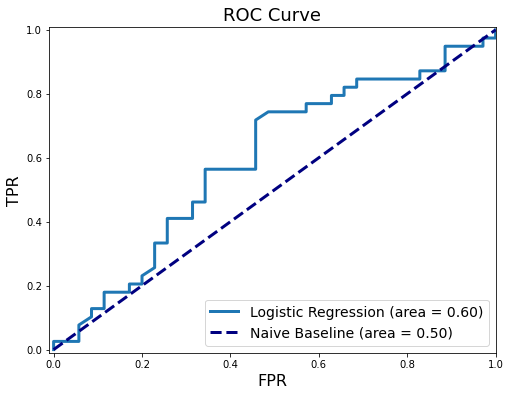

In [13]:
y_train = Team1vsTeam2_train['IsWin']
X_train = Team1vsTeam2_train.drop(['IsWin'], axis=1)
X_test = Team1vsTeam2_test.drop(['IsWin'], axis=1)

fpr, tpr, _ = roc_curve(y_test, y_prob_removedHighVIFVariable)
roc_auc = auc(fpr, tpr) #area under curve

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

---
p-value (Significance of variable)

In [14]:
# CFPM: Average combined kills per minute (teamkills + opponent kills)
# EGR: Early-Game rating
# MLR: Mid/Late rating
# FB: First Blood rate -- for players/championspercent of games earning a First Bloodparticipation (kill or assist)
# FT: First Tower rate
# HLD: Rift Herald rate
# DRG: Dragon control rate: percent of all Dragonskilled that were taken by the team, reflectingonly elemental drakes if ELD% is present
# BN: Baron control rate
# LNE: Lane control
logreg_removedHighpvalueVariable = smf.logit(formula = 'IsWin ~ WR + KD + GPR + GSPD + F3T + FD + ELD + JNG + WPM + CWPM',
                   data = Team1vsTeam2_train).fit()

print(logreg_removedHighpvalueVariable.summary())

Optimization terminated successfully.
         Current function value: 0.614307
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  IsWin   No. Observations:                  294
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           10
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.1130
Time:                        00:08:14   Log-Likelihood:                -180.61
converged:                       True   LL-Null:                       -203.62
Covariance Type:            nonrobust   LLR p-value:                 1.424e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0670      0.127      0.528      0.598      -0.182       0.316
WR             9.0420      2.

In [15]:
y_prob_removedHighpvalueVariable = logreg_removedHighpvalueVariable.predict(Team1vsTeam2_test)
y_pred_removedHighpvalueVariable = pd.Series([1 if x > 0.5 else 0 for x in y_prob_removedHighpvalueVariable], index=y_prob_removedHighpvalueVariable.index)

cm_removedHighpvalueVariable = confusion_matrix(y_test, y_pred_removedHighpvalueVariable)

# Accuracy, TPR, FPR
Acc_logit_removedHighpvalueVariable = (cm_removedHighpvalueVariable.ravel()[0]+cm_removedHighpvalueVariable.ravel()[3])/sum(cm_removedHighpvalueVariable.ravel())  # T/total = (TP+TN)/total
TPR_logit_removedHighpvalueVariable = (cm_removedHighpvalueVariable.ravel()[3])/(cm_removedHighpvalueVariable.ravel()[2] + cm_removedHighpvalueVariable.ravel()[3])  # TP/TP + FN
FPR_logit_removedHighpvalueVariable = (cm_removedHighpvalueVariable.ravel()[1])/(cm_removedHighpvalueVariable.ravel()[0] + cm_removedHighpvalueVariable.ravel()[1])  # FP/TN + FP
print('The test Accuracy after removing high p-value variables:', Acc_logit_removedHighpvalueVariable, 'TPR: ', TPR_logit_removedHighpvalueVariable, 'FPR: ', FPR_logit_removedHighpvalueVariable)

The test Accuracy after removing high p-value variables: 0.6486486486486487 TPR:  0.717948717948718 FPR:  0.42857142857142855


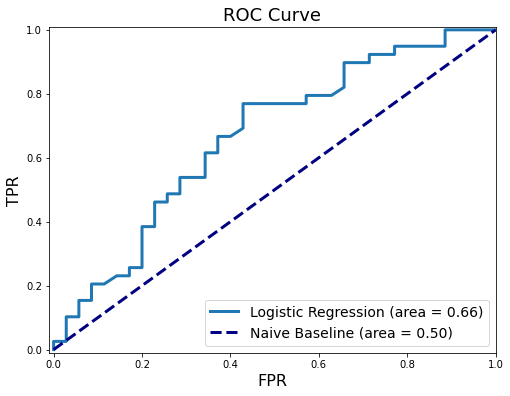

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob_removedHighpvalueVariable)
roc_auc = auc(fpr, tpr) #area under curve

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

---
### Predict the Winner
According to the tournament system, we start with the 8-in-4 prediction, the Top 8 Bo5 (five games to three wins) matches of the 2023 Worlds will be Gen.G vs BLG, NRG vs WBG, the two winners of the four teams will play in the semi-finals, with the winners advancing to the finals; meanwhile, the two winners of JDG vs KT and LNG vs T1 will play in the semi-finals, with the winners advancing to the finals. 

Since the loser of the previous game chooses either the blue or the red side for the next game, and according to the baseline model the blue side has a higher win rate than the red side, we assume that the team that loses in the previous game will choose the blue side in the next game, so we need to consider the case where the teams in the game are on both sides of the table.

In [19]:
year2023StatForWorldsTeam = pd.read_excel(r'year2023StatForWorldsTeam.xlsx') 
year2023StatForWorldsTeam.set_index("team", inplace = True)
year2023StatForWorldsTeam

,WR,KD,CKPM,GPR,GSPD,EGR,MLR,FB,FT,F3T,HLD,FD,DRG,ELD,BN,LNE,JNG,WPM,CWPM
team,,,,,,,,,,,,,,,,,,,
Gen.G,0.726562,1.53,0.75,0.88,0.075,60.8,11.9,0.61,0.66,0.64,0.53,0.44,0.59,0.60,0.64,0.509,0.550,3.13,1.21
T1,0.611511,1.10,0.77,0.79,0.040,59.8,1.4,0.51,0.72,0.71,0.61,0.61,0.58,0.50,0.61,0.504,0.514,3.32,1.40
KT Rolster,0.694215,1.52,0.69,0.61,0.045,57.5,11.9,0.55,0.61,0.64,0.45,0.55,0.60,0.73,0.62,0.506,0.505,3.19,1.37
Dplus KIA,0.606061,1.35,0.67,0.73,0.039,60.5,0.1,0.58,0.53,0.54,0.54,0.62,0.62,0.44,0.57,0.499,0.522,3.40,1.52
JD Gaming,0.777778,1.58,0.86,0.81,0.083,58.5,21.5,0.52,0.55,0.65,0.43,0.50,0.60,0.00,0.64,0.511,0.553,3.31,1.25
Bilibili Gaming,0.641379,1.21,0.91,0.85,0.053,58.7,6.9,0.57,0.52,0.76,0.48,0.59,0.56,0.00,0.59,0.502,0.531,3.32,1.32
LNG Esports,0.651786,1.39,0.81,0.42,0.045,61.4,-1.4,0.61,0.40,0.60,0.60,0.60,0.54,0.00,0.58,0.504,0.505,3.14,1.34
Weibo Gaming,0.607843,1.18,0.82,0.40,0.044,52.3,-18.9,0.45,0.67,0.67,0.50,0.67,0.51,0.00,0.59,0.506,0.520,3.21,1.39
G2 Esports,0.705263,1.36,1.02,1.00,0.069,60.1,10.5,0.48,0.61,0.57,0.64,0.60,0.59,1.00,0.63,0.500,0.539,3.15,0.95


In [20]:
# GenG in Blue
GenG_vs_BLG = year2023StatForWorldsTeam.loc[["Gen.G"]].sub(year2023StatForWorldsTeam.loc[["Bilibili Gaming"]].squeeze())
# BlG in Blue
BLG_vs_GenG = year2023StatForWorldsTeam.loc[["Bilibili Gaming"]].sub(year2023StatForWorldsTeam.loc[["Gen.G"]].squeeze())

# Predict the Winning Rate
GenG_WR = logreg_removedHighpvalueVariable.predict(GenG_vs_BLG)
BLG_WR = logreg_removedHighpvalueVariable.predict(BLG_vs_GenG)
print('The Winning Rate for Gen.G in the blue side is ', GenG_WR, '; the Winning Rate for BLG in the blue side is ', BLG_WR)

The Winning Rate for Gen.G in the blue side is  team
Gen.G    0.666887
dtype: float64 ; the Winning Rate for BLG in the blue side is  team
Bilibili Gaming    0.363519
dtype: float64


In [21]:
# NRG in Blue
NRG_vs_WBG = year2023StatForWorldsTeam.loc[["NRG"]].sub(year2023StatForWorldsTeam.loc[["Weibo Gaming"]].squeeze())
# Weibo Gaming in Blue
WBG_vs_NRG = year2023StatForWorldsTeam.loc[["Weibo Gaming"]].sub(year2023StatForWorldsTeam.loc[["NRG"]].squeeze())

# Predict the Winning Rate
NRG_WR = logreg_removedHighpvalueVariable.predict(NRG_vs_WBG)
WBG_WR = logreg_removedHighpvalueVariable.predict(WBG_vs_NRG)
print('The Winning Rate for NRG in the blue side is ', NRG_WR, '; the Winning Rate for WBG in the blue side is ', WBG_WR)

The Winning Rate for NRG in the blue side is  team
NRG    0.648228
dtype: float64 ; the Winning Rate for WBG in the blue side is  team
Weibo Gaming    0.382903
dtype: float64


In [22]:
# JDG in Blue
JDG_vs_KT = year2023StatForWorldsTeam.loc[["JD Gaming"]].sub(year2023StatForWorldsTeam.loc[["KT Rolster"]].squeeze())
# KT in Blue
KT_vs_JDG = year2023StatForWorldsTeam.loc[["KT Rolster"]].sub(year2023StatForWorldsTeam.loc[["JD Gaming"]].squeeze())

# Predict the Winning Rate
JDG_WR = logreg_removedHighpvalueVariable.predict(JDG_vs_KT)
KT_WR = logreg_removedHighpvalueVariable.predict(KT_vs_JDG)
print('The Winning Rate for JDG in the blue side is ', JDG_WR, '; the Winning Rate for KT in the blue side is ', KT_WR)

The Winning Rate for JDG in the blue side is  team
JD Gaming    0.573063
dtype: float64 ; the Winning Rate for KT in the blue side is  team
KT Rolster    0.459999
dtype: float64


In [23]:
# LNG in Blue
LNG_vs_T1 = year2023StatForWorldsTeam.loc[["LNG Esports"]].sub(year2023StatForWorldsTeam.loc[["T1"]].squeeze())
# T1 in Blue
T1_vs_LNG = year2023StatForWorldsTeam.loc[["T1"]].sub(year2023StatForWorldsTeam.loc[["LNG Esports"]].squeeze())

# Predict the Winning Rate
LNG_WR = logreg_removedHighpvalueVariable.predict(LNG_vs_T1)
T1_WR = logreg_removedHighpvalueVariable.predict(T1_vs_LNG)
print('The Winning Rate for LNG in the blue side is ', LNG_WR, '; the Winning Rate for T1 in the blue side is ', T1_WR)

The Winning Rate for LNG in the blue side is  team
LNG Esports    0.341437
dtype: float64 ; the Winning Rate for T1 in the blue side is  team
T1    0.688027
dtype: float64


#### Semifinals

In [24]:
# GenG in Blue
GenG_vs_NRG = year2023StatForWorldsTeam.loc[["Gen.G"]].sub(year2023StatForWorldsTeam.loc[["NRG"]].squeeze())
# NRG in Blue
NRG_vs_GenG = year2023StatForWorldsTeam.loc[["NRG"]].sub(year2023StatForWorldsTeam.loc[["Gen.G"]].squeeze())

# Predict the Winning Rate
GenG_WR_semi = logreg_removedHighpvalueVariable.predict(GenG_vs_NRG)
NRG_WR_semi = logreg_removedHighpvalueVariable.predict(NRG_vs_GenG)
print('The Winning Rate for Gen.G in the blue side is ', GenG_WR_semi, '; the Winning Rate for NRG in the blue side is ', NRG_WR_semi)

The Winning Rate for Gen.G in the blue side is  team
Gen.G    0.682754
dtype: float64 ; the Winning Rate for NRG in the blue side is  team
NRG    0.346957
dtype: float64


In [25]:
# JDG in Blue
JDG_vs_T1 = year2023StatForWorldsTeam.loc[["JD Gaming"]].sub(year2023StatForWorldsTeam.loc[["T1"]].squeeze())
# T1 in Blue
T1_vs_JDG = year2023StatForWorldsTeam.loc[["T1"]].sub(year2023StatForWorldsTeam.loc[["JD Gaming"]].squeeze())

# Predict the Winning Rate
JDG_WR_semi = logreg_removedHighpvalueVariable.predict(JDG_vs_T1)
T1_WR_semi = logreg_removedHighpvalueVariable.predict(T1_vs_JDG)
print('The Winning Rate for JDG in the blue side is ', JDG_WR_semi, '; the Winning Rate for T1 in the blue side is ', T1_WR_semi)

The Winning Rate for JDG in the blue side is  team
JD Gaming    0.594402
dtype: float64 ; the Winning Rate for T1 in the blue side is  team
T1    0.438272
dtype: float64


#### Final

In [26]:
# GenG in Blue
GenG_vs_JDG = year2023StatForWorldsTeam.loc[["Gen.G"]].sub(year2023StatForWorldsTeam.loc[["JD Gaming"]].squeeze())
# JDG in Blue
JDG_vs_GenG = year2023StatForWorldsTeam.loc[["JD Gaming"]].sub(year2023StatForWorldsTeam.loc[["Gen.G"]].squeeze())

# Predict the Winning Rate
GenG_WR_final = logreg_removedHighpvalueVariable.predict(GenG_vs_JDG)
JDG_WR_final = logreg_removedHighpvalueVariable.predict(JDG_vs_GenG)
print('The Winning Rate for Gen.G in the blue side is ', GenG_WR_final, '; the Winning Rate for JDG in the blue side is ', JDG_WR_final)

The Winning Rate for Gen.G in the blue side is  team
Gen.G    0.517303
dtype: float64 ; the Winning Rate for JDG in the blue side is  team
JD Gaming    0.516188
dtype: float64


By the Prediction of using Logistic Regression, The winner is Gen.G

___
### 2023 Season World Championship:
#### T1 3:0 WBG 
Game 1: WBG 0 T1 1    
Game 2: WBG 0 T1 1    
Game 3: WBG 0 T1 1

In [27]:
# WBG in Blue vs T1 in red
WBG_vs_T1_Final = year2023StatForWorldsTeam.loc[["Weibo Gaming"]].sub(year2023StatForWorldsTeam.loc[["T1"]].squeeze())
# T1 in Blue vs WBG in red
T1_vs_WBG_Final = year2023StatForWorldsTeam.loc[["T1"]].sub(year2023StatForWorldsTeam.loc[["Weibo Gaming"]].squeeze())

# Predict the Winning Rate
WBG_WR_final = logreg_removedHighpvalueVariable.predict(WBG_vs_T1_Final)
T1_WR_final = logreg_removedHighpvalueVariable.predict(T1_vs_WBG_Final)
print('The Winning Rate for WBG in the blue side is ', WBG_WR_final, '; the Winning Rate for T1 in the blue side is ', T1_WR_final)

The Winning Rate for WBG in the blue side is  team
Weibo Gaming    0.297489
dtype: float64 ; the Winning Rate for T1 in the blue side is  team
T1    0.729739
dtype: float64


From the above report we can see that the winning rate for WBG in blue side in 30% and for T1 in blue side is 73% which matches the condition that T1 3:0 WBG